In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import xgboost as xgb
import optuna
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve

import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.simplefilter("ignore", category=ConvergenceWarning)

RANDOM_STATE = 21
torch.manual_seed(21)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

C:\Users\lambe\miniconda3\envs\Spotify_prediction\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

# Data Collection

Considering that music preferences have changed over the years, I assumed that the decade in which the song was released was a sign worthy of attention

In [2]:
df_60 = pd.read_csv("data/dataset-of-60s.csv")
df_60['decade_of_release'] = '60'
df_70 = pd.read_csv("data/dataset-of-70s.csv")
df_70['decade_of_release'] = '70'
df_80 = pd.read_csv("data/dataset-of-80s.csv")
df_80['decade_of_release'] = '80'
df_90 = pd.read_csv("data/dataset-of-90s.csv")
df_90['decade_of_release'] = '90'
df_00 = pd.read_csv("data/dataset-of-00s.csv")
df_00['decade_of_release'] = '0'
df_10 = pd.read_csv("data/dataset-of-10s.csv")
df_10['decade_of_release'] = '10'
df = pd.concat([df_00, df_10, df_60, df_70, df_80, df_90])
df = df[['uri','track','artist','danceability','energy','key','loudness',
  'mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature','chorus_hit','sections','decade_of_release','target']]
df

,uri,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade_of_release,target
0,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,Lucky Man,Montgomery Gentry,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,0,1
1,spotify:track:1zyqZONW985Cs4osz9wlsu,On The Hotline,Pretty Ricky,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,0,1
2,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,Clouds Of Dementia,Candlemass,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0,0
3,spotify:track:2IjBPp2vMeX7LggzRN3iSX,"Heavy Metal, Raise Hell!",Zwartketterij,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,4,58.59528,9,0,0
4,spotify:track:1tF370eYXUcWwkIvaq3IGz,I Got A Feelin',Billy Currington,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,(You're A) Go Nowhere,Reagan Youth,0.396,0.795,9,-6.070,0,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,4,30.34109,6,90,0
5516,spotify:track:43DFcnOZprnVlAFKwgBJ3e,La Fiebre de Norma,La Castañeda,0.621,0.655,9,-6.281,0,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,4,34.89506,10,90,0
5517,spotify:track:6UPfnVoOq3y3BvapBIKs8J,Good Times,Edie Brickell,0.562,0.314,10,-15.213,0,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,90,1
5518,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,Inane,KMFDM,0.622,0.781,7,-6.080,1,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,4,47.13558,11,90,0


# Preprocessing

Finding the number of rows and columns

In [3]:
df.shape

(41106, 20)

searching for unique artists and track names

In [4]:
print(f'Unique artists - {len(df['artist'].unique())}\nUnique track names - {len(df['track'].unique())}')

Unique artists - 11904
Unique track names - 35860


Exploring data types and checking for nulls

In [5]:
df

,uri,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,decade_of_release,target
0,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,Lucky Man,Montgomery Gentry,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,0,1
1,spotify:track:1zyqZONW985Cs4osz9wlsu,On The Hotline,Pretty Ricky,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,0,1
2,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,Clouds Of Dementia,Candlemass,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0,0
3,spotify:track:2IjBPp2vMeX7LggzRN3iSX,"Heavy Metal, Raise Hell!",Zwartketterij,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,4,58.59528,9,0,0
4,spotify:track:1tF370eYXUcWwkIvaq3IGz,I Got A Feelin',Billy Currington,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,(You're A) Go Nowhere,Reagan Youth,0.396,0.795,9,-6.070,0,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,4,30.34109,6,90,0
5516,spotify:track:43DFcnOZprnVlAFKwgBJ3e,La Fiebre de Norma,La Castañeda,0.621,0.655,9,-6.281,0,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,4,34.89506,10,90,0
5517,spotify:track:6UPfnVoOq3y3BvapBIKs8J,Good Times,Edie Brickell,0.562,0.314,10,-15.213,0,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,90,1
5518,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,Inane,KMFDM,0.622,0.781,7,-6.080,1,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,4,47.13558,11,90,0


Checking for nulls again. Making doubly sure

In [6]:
df.isnull().sum()

uri                  0
track                0
artist               0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
chorus_hit           0
sections             0
decade_of_release    0
target               0
dtype: int64

We can see that there are no null values in the dataset. Taking the rough statistics of the data.

In [7]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599792,8.000000,0.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000


In [8]:
df['time_signature'].describe()

count    41106.000000
mean         3.893689
std          0.423073
min          0.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64

column time signature will be droped as most values are 4.

In [9]:
#Scaling the data
scale = StandardScaler()

df_X = df.drop(axis=1, labels=['time_signature','uri','target', 'track', 'artist'])


df_scaled = scale.fit_transform(df_X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_X.columns
df_scaled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit,sections,decade_of_release
0,0.215416,-0.429668,-0.343315,0.555679,0.665030,-0.511673,0.011220,-0.508740,-0.245926,-0.039055,0.471597,-0.320853,-0.485415,0.518152,-1.625366
1,0.924004,1.086412,1.354030,0.893245,-1.503691,1.277886,-1.020031,-0.508740,-0.309525,0.544503,-0.905554,0.064804,0.073928,-0.097638,-1.625366
2,-2.124046,1.015160,1.071139,1.357892,0.665030,-0.297994,-1.074290,-0.493684,-0.159199,-0.906910,-1.112575,0.874330,1.327148,0.518152,-1.625366
3,-1.977830,1.640592,-0.343315,1.219326,0.665030,1.080465,-1.074596,-0.250443,-0.055127,-0.783465,1.000112,0.174751,0.972847,-0.302901,-1.625366
4,0.507849,0.730153,-0.909096,1.104859,0.665030,-0.527931,-0.003533,-0.508740,-0.442506,0.331280,-0.248819,-0.345625,-0.919860,-0.097638,-1.625366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,-0.808099,0.852864,1.071139,0.781602,-1.503691,1.870147,-1.071880,-0.508052,-0.112945,0.821319,1.154862,-1.284154,-0.513802,-0.918691,1.138569
41102,0.457236,0.298684,1.071139,0.741877,-1.503691,-0.488447,-0.925315,-0.488116,-0.623476,0.551984,0.509605,-0.195220,-0.274186,-0.097638,1.138569
41103,0.125437,-1.051141,1.354030,-0.939738,-1.503691,-0.501221,0.223667,-0.508704,-0.552360,0.106835,1.632688,-0.378684,-0.999112,-0.097638,1.138569
41104,0.462860,0.797446,0.505358,0.779719,0.665030,-0.419930,-1.074320,1.978688,1.049193,-1.228615,0.024494,0.800023,0.369873,0.107625,1.138569


Managing outliers and creating boxplots to analyze the distribution of data and remove outliers

Text(0.5, 1.0, 'Distribution of predictors with outliers')

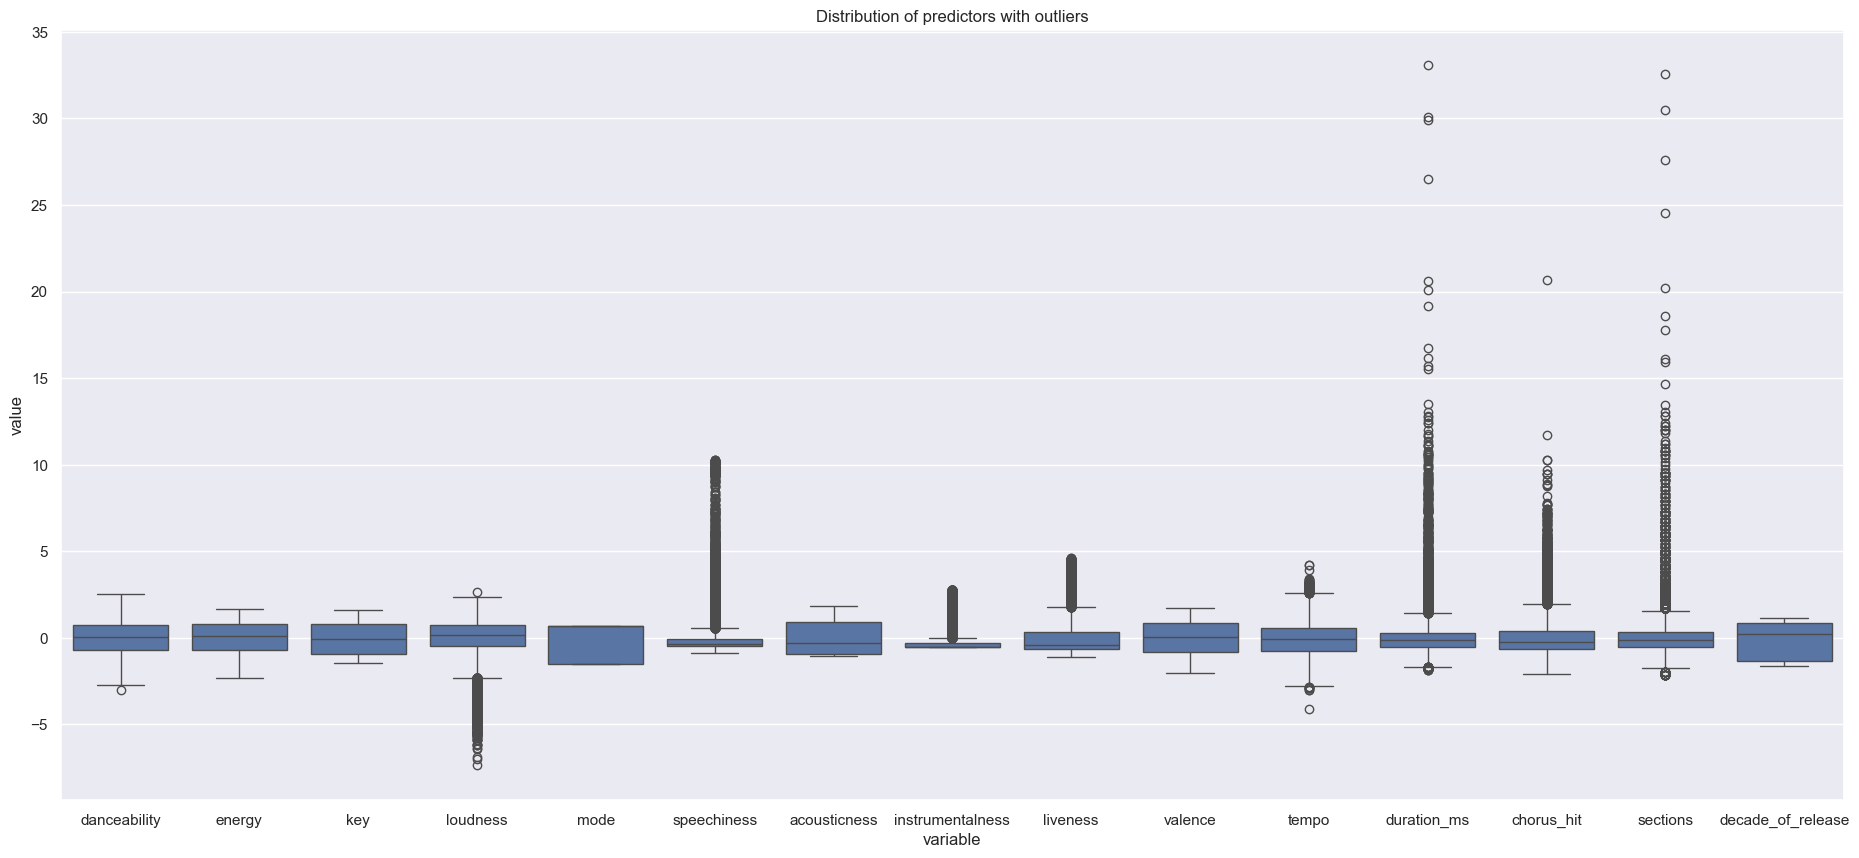

In [10]:
#box plot with outliers
df_melt=pd.melt(df_scaled)
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt)
plt.title('Distribution of predictors with outliers')

Text(0.5, 1.0, 'Distribution of predictors without outliers')

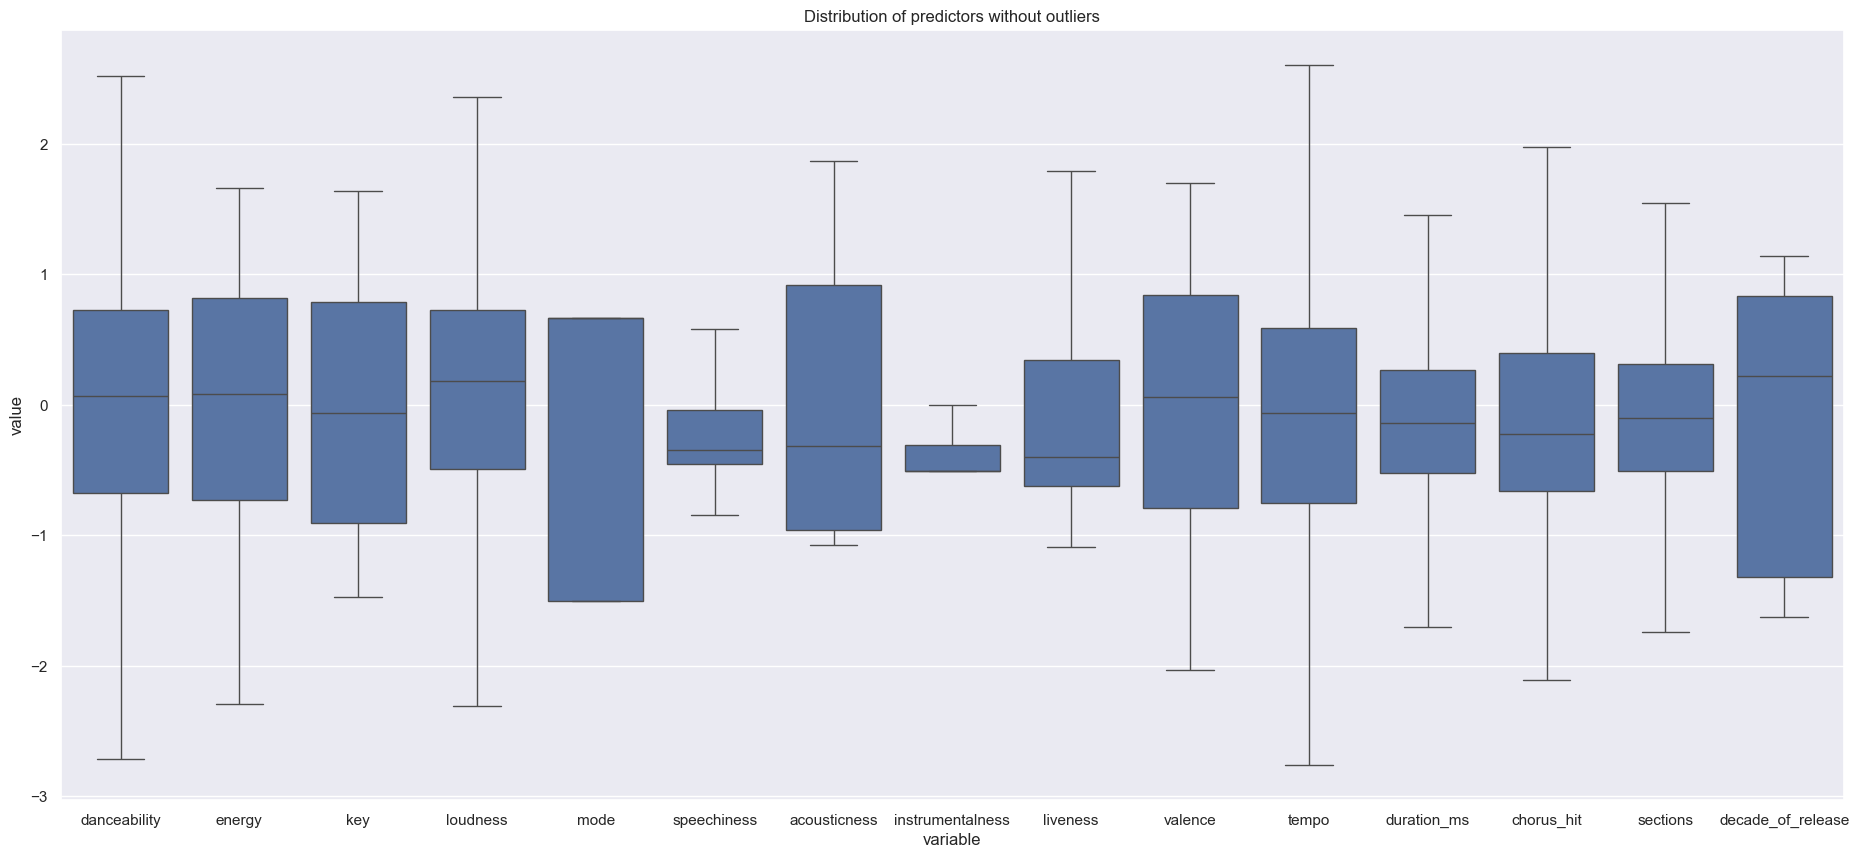

In [11]:
#boxplot without outliers
df_melt=pd.melt(df_scaled)
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False)
plt.title('Distribution of predictors without outliers')

Removing the outliers

In [12]:
df_clean = df_scaled
for col in df_clean.columns:
  q1=df_clean[col].quantile(0.25)
  q3=df_clean[col].quantile(0.75)
  inq=q3-q1
  filter=(df_clean[col] >= q1-1.5*inq) & (df_clean[col] <= q3+1.5*inq)
  df_clean[col] = df_clean[col].loc[filter]

In [13]:
#number of outliers for each predictor
df_clean.isna().sum()

danceability            1
energy                  0
key                     0
loudness             1343
mode                    0
speechiness          5088
acousticness            0
instrumentalness     8920
liveness             2688
valence                 0
tempo                 434
duration_ms          1987
chorus_hit           1839
sections             1570
decade_of_release       0
dtype: int64

Removing 2 predictors with a lot of outliers

In [14]:
#removing 2 predictors
df_clean = df_clean.drop(axis=1, labels=['speechiness', 'instrumentalness'])

In [15]:
df_remove = df_clean.dropna()
df_remove.shape

(33401, 13)

Total of 33401 songs remain after cleaning

Text(0.5, 1.0, 'Distribution of predictors without outliers')

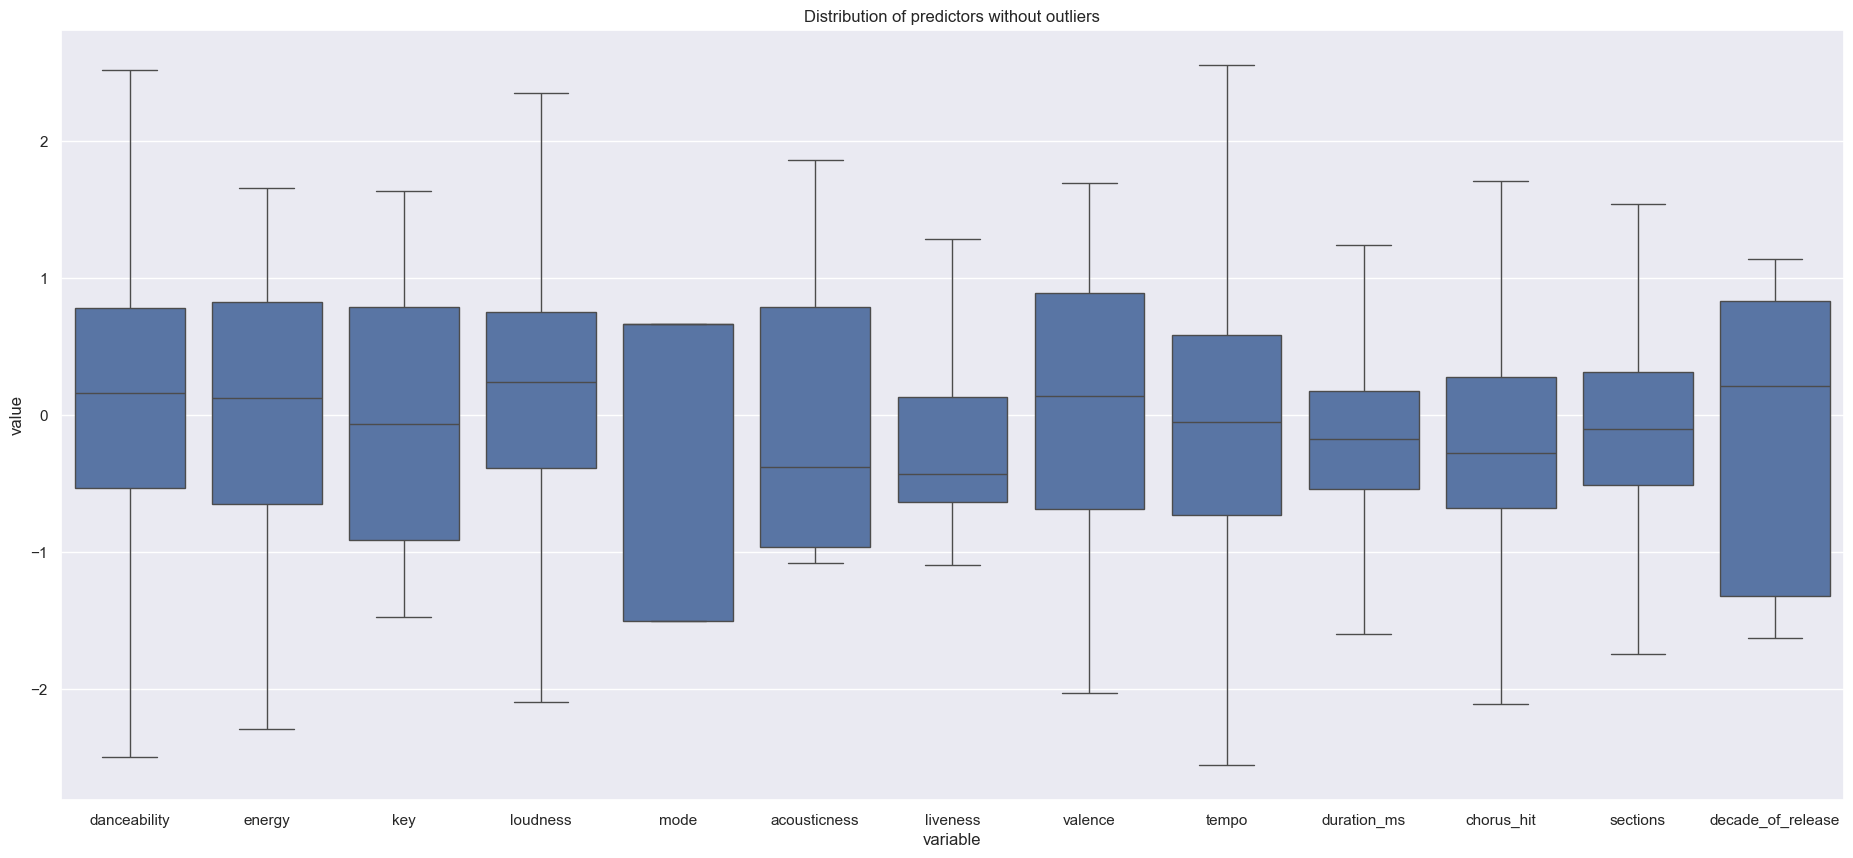

In [16]:
#box plot after removing the outliers
df_melt=pd.melt(df_remove)
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False)
plt.title('Distribution of predictors without outliers')

Creating the unscaled dataframe without the outliers

In [17]:
df_merge = df.iloc[df_remove.index]

In [18]:
df_merge = df_merge.drop(axis=1, labels=['speechiness', 'instrumentalness'])

In [19]:
df_merge.columns

Index(['uri', 'track', 'artist', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'chorus_hit', 'sections', 'decade_of_release',
       'target'],
      dtype='object')

Counting the number of observations in each class

In [20]:
#observations in each class
df_merge.groupby('target')[['danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'chorus_hit', 'sections']].count()

,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,duration_ms,chorus_hit,sections
target,,,,,,,,,,,,
0,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247
1,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154


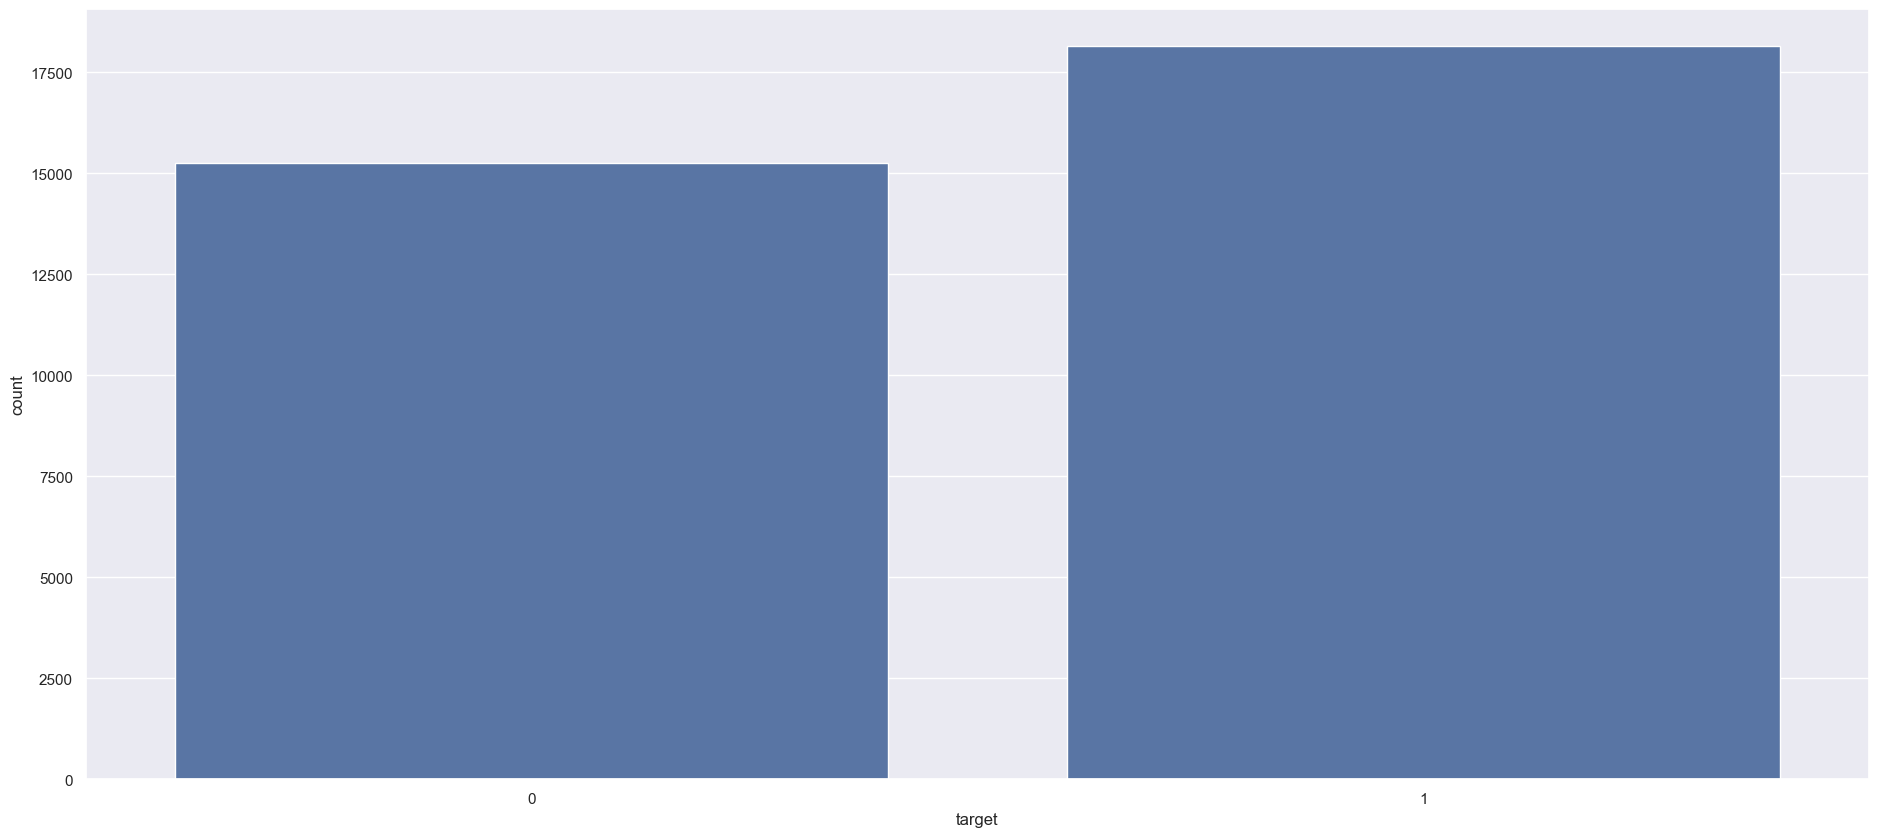

In [21]:
#plotting the number of observations
sns.countplot(x='target', data=df_merge)
sns.set_theme(rc={'figure.figsize':(12,8)})

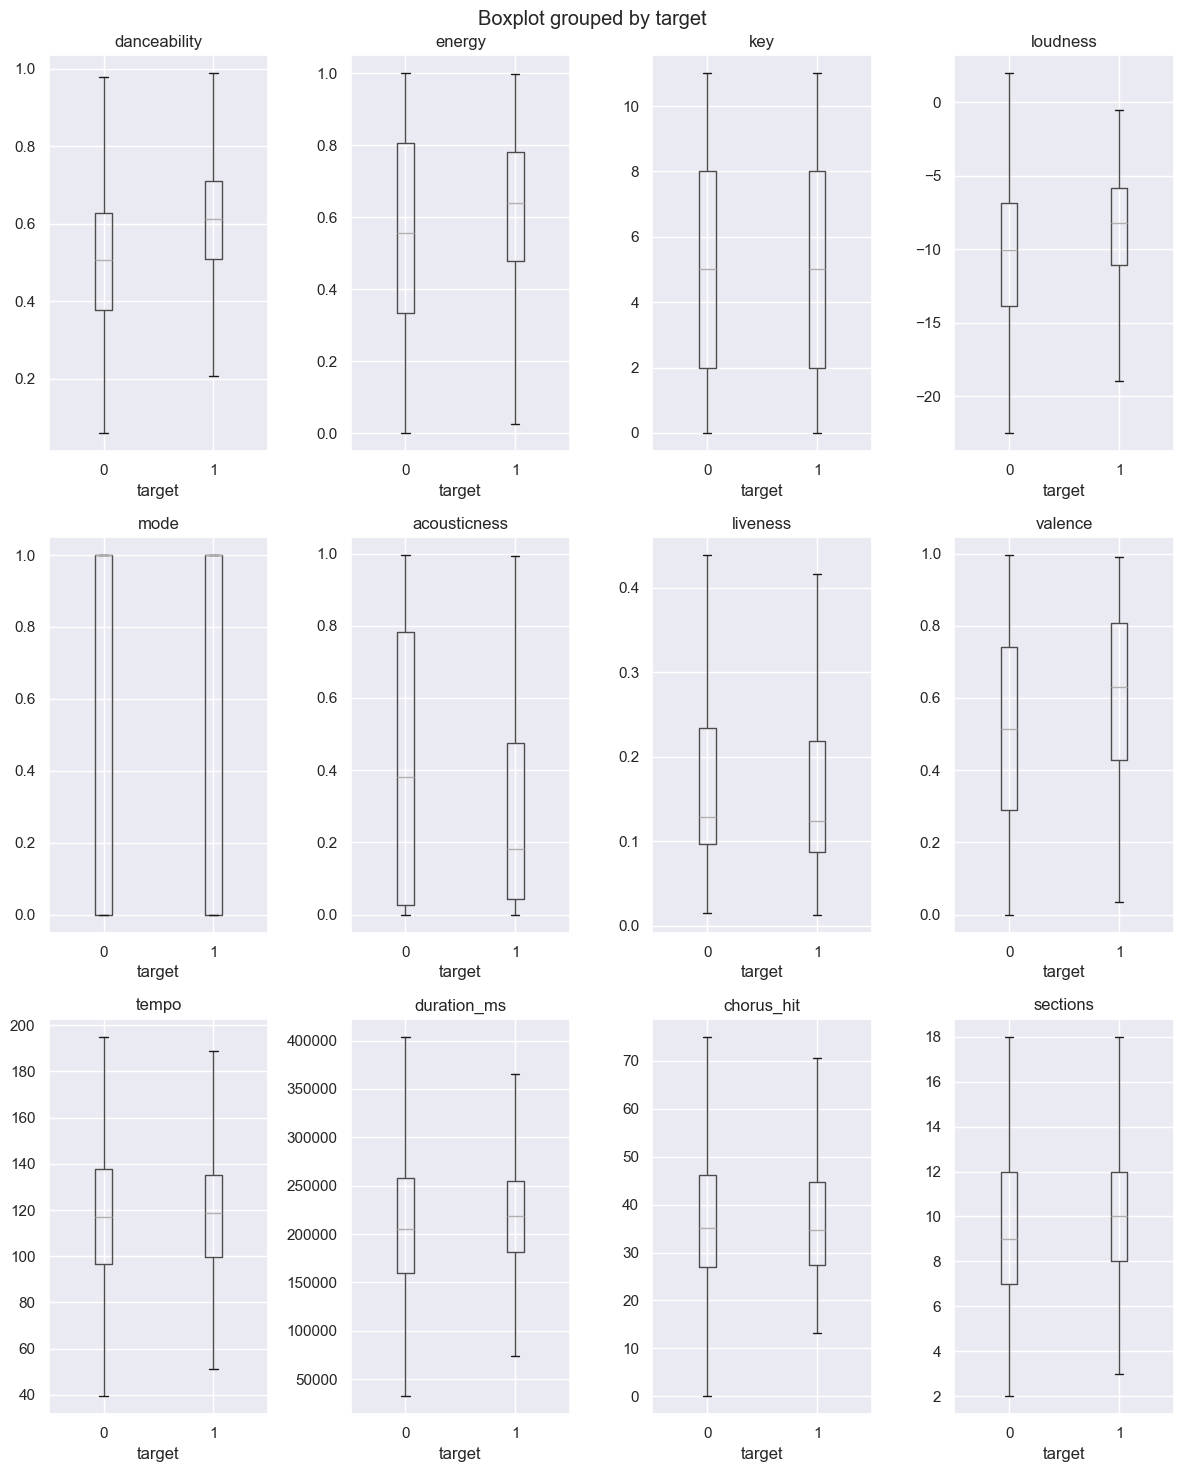

In [22]:
#plotting box plots based on target variable for different predictors
plt.rcParams["figure.figsize"] = [12, 15]
fig, axes = plt.subplots(nrows=3, ncols=4, )
df_merge.boxplot(column= 'danceability', by='target', ax=axes[0][0], showfliers=False)
df_merge.boxplot(column= 'energy', by='target', ax=axes[0][1], showfliers=False)
df_merge.boxplot(column='key', by='target', ax=axes[0][2], showfliers=False)
df_merge.boxplot(column='loudness', by='target', ax=axes[0][3], showfliers=False)
df_merge.boxplot(column='mode', by='target', ax=axes[1][0], showfliers=False)
df_merge.boxplot(column='acousticness', by='target', ax=axes[1][1], showfliers=False)
df_merge.boxplot(column='liveness', by='target', ax=axes[1][2], showfliers=False)
df_merge.boxplot(column='valence', by='target', ax=axes[1][3], showfliers=False)
df_merge.boxplot(column='tempo', by='target', ax=axes[2][0], showfliers=False)
df_merge.boxplot(column='duration_ms', by='target', ax=axes[2][1], showfliers=False)
df_merge.boxplot(column='chorus_hit', by='target', ax=axes[2][2], showfliers=False)
df_merge.boxplot(column='sections', by='target', ax=axes[2][3], showfliers=False)
plt.tight_layout()
plt.show()

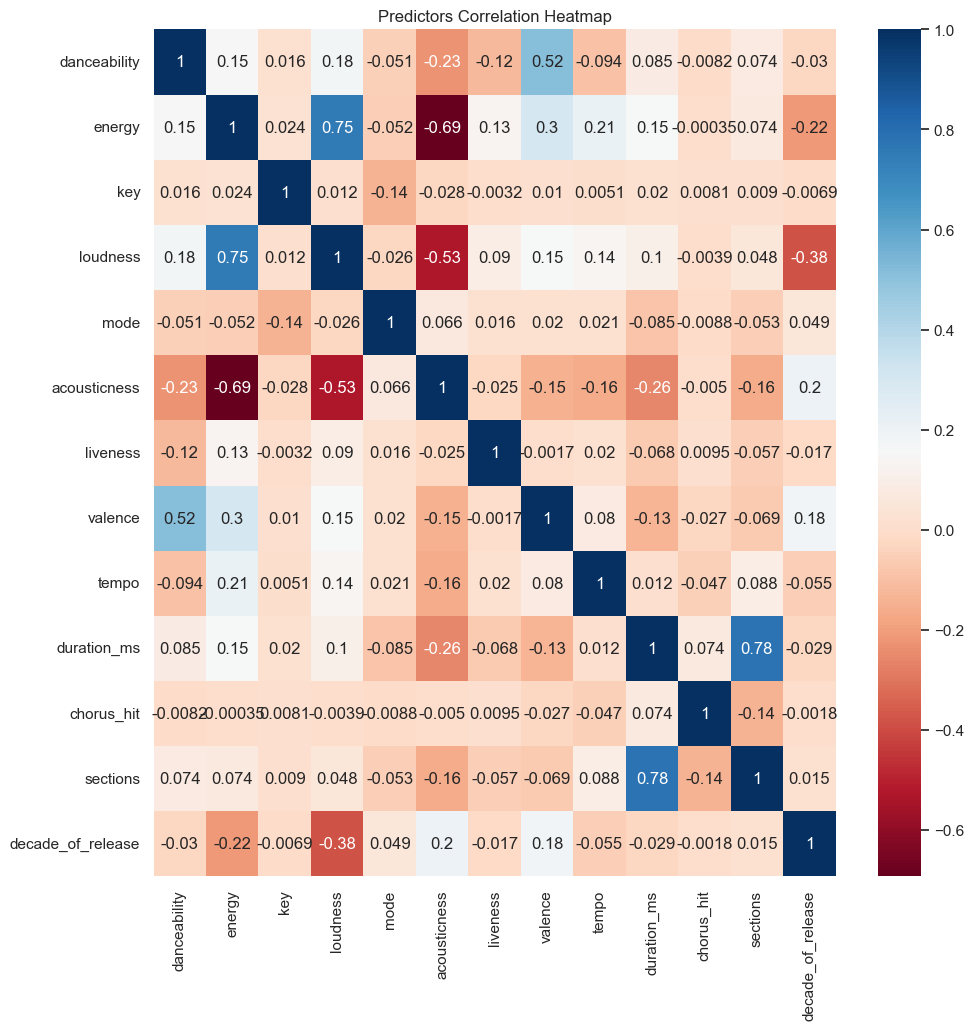

In [23]:
#correlation between the predictors
fig, ax = plt.subplots(figsize=(11,11)) 
ax = sns.heatmap(df_remove.corr(), annot=True, cmap='RdBu').set(title='Predictors Correlation Heatmap')

# Building the Model

Creating X and Y

In [24]:
X = df_merge.iloc[:,1:17]

In [25]:
X.shape

(33401, 16)

In [26]:
y = df_merge['target']
y.shape

(33401,)

In [27]:
#create embeddings
X = X.reset_index(drop=True)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
title_embeddings = sbert_model.encode(X['track'].tolist())
title_emb_df = pd.DataFrame(title_embeddings,
                           columns=[f'track_emb_{i}' for i in range(title_embeddings.shape[1])])
X = pd.concat([X.drop(columns=['track']), title_emb_df], axis=1).reset_index(drop=True)

In [28]:
X

,artist,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,...,track_emb_374,track_emb_375,track_emb_376,track_emb_377,track_emb_378,track_emb_379,track_emb_380,track_emb_381,track_emb_382,track_emb_383
0,Montgomery Gentry,0.578,0.471,4,-7.270,1,0.368000,0.1590,0.532,133.061,...,-0.019067,-0.027637,-0.001098,0.004216,-0.015133,-0.036565,0.123235,-0.079107,-0.104993,0.067361
1,Pretty Ricky,0.704,0.854,10,-5.477,0,0.018500,0.1480,0.688,92.988,...,-0.080652,-0.104472,0.026485,-0.042151,-0.015728,0.035541,0.113025,0.045435,-0.081078,0.020217
2,Candlemass,0.162,0.836,9,-3.009,1,0.000111,0.1740,0.300,86.964,...,-0.026394,0.019266,0.006533,0.008130,-0.055564,-0.049505,0.131710,0.041360,0.030400,0.036595
3,Zwartketterij,0.188,0.994,4,-3.745,1,0.000007,0.1920,0.333,148.440,...,0.061416,0.035733,0.004343,0.050908,-0.080520,0.045158,0.088918,-0.135694,0.047798,0.058296
4,Billy Currington,0.630,0.764,2,-4.353,1,0.363000,0.1250,0.631,112.098,...,0.117432,-0.086882,0.057570,0.048860,-0.034742,0.038969,-0.019049,0.031466,-0.026418,-0.012443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33396,Reagan Youth,0.396,0.795,9,-6.070,0,0.000928,0.1820,0.762,152.943,...,0.094730,-0.029172,-0.017985,0.017851,-0.048188,0.036629,0.082673,0.058863,-0.007090,-0.065915
33397,La Castañeda,0.621,0.655,9,-6.281,0,0.050600,0.0937,0.690,134.167,...,-0.038869,-0.025881,0.012162,0.086097,-0.027411,-0.072995,0.099734,0.094557,0.042427,-0.071927
33398,Edie Brickell,0.562,0.314,10,-15.213,0,0.440000,0.1060,0.571,166.847,...,0.027974,0.044029,0.006562,-0.052720,-0.027563,-0.046869,0.065921,0.051971,-0.035787,0.007025
33399,KMFDM,0.622,0.781,7,-6.080,1,0.000101,0.3830,0.214,120.051,...,0.080360,0.032526,-0.000016,0.035505,0.019707,0.004403,0.111630,-0.031499,-0.041450,0.053986


In [29]:
X.shape

(33401, 399)

In [30]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, train_size=0.75, shuffle=True, random_state=RANDOM_STATE)

# First Model Training

In [31]:
#define models
models = {
    "                   Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=500000),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(random_state=RANDOM_STATE, max_iter=500000),
    "   Support Vector Machine (RBF Kernel)": SVC(random_state=RANDOM_STATE, max_iter=500000),
    "               Neural Network(sklearn)": MLPClassifier(max_iter=500000, random_state=RANDOM_STATE),
    "                         Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "                              Catboost": CatBoostClassifier(logging_level = 'Silent',random_state=RANDOM_STATE),
    "                               Xgboost": xgb.XGBClassifier(random_state=RANDOM_STATE),
    "                                   LDA": LinearDiscriminantAnalysis(),
    "                           Naive Bayes": GaussianNB(),
    "                                 Ridge": Ridge(random_state=RANDOM_STATE, max_iter=500000),
}
#define preprocessor
categorical_cols = ['artist', 'decade_of_release']
numerical_cols = [col for col in X.columns if col not in categorical_cols]
preprocessor = ColumnTransformer([
    ('artist_encoder', TargetEncoder(smooth="auto", random_state=RANDOM_STATE), ['artist']),
    ('decade_encoder', OneHotEncoder(drop='first', sparse_output=False), ['decade_of_release']),
    ('scaler', StandardScaler(), numerical_cols)
], remainder='passthrough')

In [32]:
#3-fold cross validation for choosing the top models
mean_df = []
for name, model in models.items():
    mean_arr = {}
    cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)])
    cv_results = cross_val_score(pipe, X_train_valid, y_train_valid, cv=cv)
    mean = np.mean(cv_results)
    print(name, mean)
    mean_arr['name']=name
    mean_arr['result']=mean
    mean_df.append(mean_arr)

                   Logistic Regression 0.9532559850916155
                   K-Nearest Neighbors 0.75976790316902
Support Vector Machine (Linear Kernel) 0.9528817349942553
   Support Vector Machine (RBF Kernel) 0.9302022370829719
               Neural Network(sklearn) 0.9420285452020524
                         Random Forest 0.9465943518477689
                              Catboost 0.9590944303216644
                               Xgboost 0.9566243872428365
                                   LDA 0.9540420561083437
                           Naive Bayes 0.8589444352965102
                                 Ridge 0.7877360644237127


In [33]:
pd.DataFrame(mean_df).sort_values('result',ascending=False)

,name,result
6,Catboost,0.959094
7,Xgboost,0.956624
8,LDA,0.954042
0,Logistic Regression,0.953256
2,Support Vector Machine (Linear Kernel),0.952882
5,Random Forest,0.946594
4,Neural Network(sklearn),0.942029
3,Support Vector Machine (RBF Kernel),0.930202
9,Naive Bayes,0.858944
10,Ridge,0.787736


### Intermediate conclusions
We have three directions in which we can go in search of the best possible outcome
1. Gradient boosting
2. Regression
3. Neural Network


Good NN result can be achieved by using Torch model. For other models i can use hyperparameter tuning

# **Hyperparameter tuning and choosing the best model**

### Log regression

In [34]:
def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])

    params = {
        'penalty': penalty,
        'C': trial.suggest_float('C', 1e-4, 100, log=True),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 10000, 500000),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': RANDOM_STATE
    }

    if penalty == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)

    if penalty == 'none':
        params.pop('C', None)
        params.pop('l1_ratio', None)

    try:
        reg_model = LogisticRegression(**params)
        reg_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', reg_model)
        ])
        reg_pipe.fit(X_train, y_train)
        predictions = reg_pipe.predict(X_valid)
        score = accuracy_score(y_valid, predictions)
        return score
    except ValueError as e:
        print(f"skipping incompatible parameters: {params}, err: {str(e)}")
        return 0.0

reg_study = optuna.create_study(direction='maximize')
reg_study.optimize(objective, n_trials=30)
print(f'Best hyperparameters: {reg_study.best_params}')
print(f'Best accuracy_score: {reg_study.best_value}')

[I 2025-06-02 17:49:32,478] A new study created in memory with name: no-name-0ab425de-0175-42fc-9955-5a9cb92b3869
[I 2025-06-02 17:49:32,718] Trial 0 finished with value: 0.0 and parameters: {'penalty': 'none', 'C': 70.58864828079946, 'solver': 'saga', 'max_iter': 24747, 'class_weight': None}. Best is trial 0 with value: 0.0.


skipping incompatible parameters: {'penalty': 'none', 'solver': 'saga', 'max_iter': 24747, 'class_weight': None, 'random_state': 21}, err: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.


[I 2025-06-02 17:49:32,986] Trial 1 finished with value: 0.0 and parameters: {'penalty': 'none', 'C': 1.798351515472495, 'solver': 'newton-cg', 'max_iter': 182935, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.0.


skipping incompatible parameters: {'penalty': 'none', 'solver': 'newton-cg', 'max_iter': 182935, 'class_weight': 'balanced', 'random_state': 21}, err: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.


[I 2025-06-02 17:49:37,678] Trial 2 finished with value: 0.9537425149700599 and parameters: {'penalty': 'l2', 'C': 6.963940574825558, 'solver': 'liblinear', 'max_iter': 86228, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9537425149700599.
[I 2025-06-02 17:49:37,907] Trial 3 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 10.38124182812931, 'solver': 'sag', 'max_iter': 41700, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9537425149700599.


skipping incompatible parameters: {'penalty': 'l1', 'C': 10.38124182812931, 'solver': 'sag', 'max_iter': 41700, 'class_weight': 'balanced', 'random_state': 21}, err: Solver sag supports only 'l2' or None penalties, got l1 penalty.


[I 2025-06-02 17:49:38,150] Trial 4 finished with value: 0.0 and parameters: {'penalty': 'elasticnet', 'C': 41.056186595690754, 'solver': 'liblinear', 'max_iter': 16664, 'class_weight': None, 'l1_ratio': 0.26805687287866675}. Best is trial 2 with value: 0.9537425149700599.


skipping incompatible parameters: {'penalty': 'elasticnet', 'C': 41.056186595690754, 'solver': 'liblinear', 'max_iter': 16664, 'class_weight': None, 'random_state': 21, 'l1_ratio': 0.26805687287866675}, err: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.


[I 2025-06-02 17:49:38,392] Trial 5 finished with value: 0.0 and parameters: {'penalty': 'none', 'C': 0.39750402784342426, 'solver': 'liblinear', 'max_iter': 135425, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9537425149700599.


skipping incompatible parameters: {'penalty': 'none', 'solver': 'liblinear', 'max_iter': 135425, 'class_weight': 'balanced', 'random_state': 21}, err: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.


[I 2025-06-02 17:49:58,261] Trial 6 finished with value: 0.9544910179640719 and parameters: {'penalty': 'l1', 'C': 0.2920963286435906, 'solver': 'saga', 'max_iter': 418225, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.9544910179640719.
[I 2025-06-02 17:49:58,477] Trial 7 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.017761044318275507, 'solver': 'sag', 'max_iter': 485731, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.9544910179640719.


skipping incompatible parameters: {'penalty': 'l1', 'C': 0.017761044318275507, 'solver': 'sag', 'max_iter': 485731, 'class_weight': 'balanced', 'random_state': 21}, err: Solver sag supports only 'l2' or None penalties, got l1 penalty.
skipping incompatible parameters: {'penalty': 'none', 'solver': 'sag', 'max_iter': 65176, 'class_weight': 'balanced', 'random_state': 21}, err: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.


[I 2025-06-02 17:49:58,686] Trial 8 finished with value: 0.0 and parameters: {'penalty': 'none', 'C': 0.07869375057801636, 'solver': 'sag', 'max_iter': 65176, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.9544910179640719.
[I 2025-06-02 17:49:58,935] Trial 9 finished with value: 0.0 and parameters: {'penalty': 'none', 'C': 0.0005462403512567694, 'solver': 'lbfgs', 'max_iter': 206414, 'class_weight': None}. Best is trial 6 with value: 0.9544910179640719.


skipping incompatible parameters: {'penalty': 'none', 'solver': 'lbfgs', 'max_iter': 206414, 'class_weight': None, 'random_state': 21}, err: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.


[I 2025-06-02 17:50:00,498] Trial 10 finished with value: 0.9220059880239521 and parameters: {'penalty': 'l1', 'C': 0.0012173424369836964, 'solver': 'saga', 'max_iter': 378038, 'class_weight': None}. Best is trial 6 with value: 0.9544910179640719.
[I 2025-06-02 17:50:05,274] Trial 11 finished with value: 0.9537425149700599 and parameters: {'penalty': 'l2', 'C': 2.006761108343864, 'solver': 'liblinear', 'max_iter': 322960, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.9544910179640719.
[I 2025-06-02 17:50:07,480] Trial 12 finished with value: 0.9519461077844311 and parameters: {'penalty': 'l2', 'C': 0.01581906515156383, 'solver': 'saga', 'max_iter': 424337, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.9544910179640719.
[I 2025-06-02 17:50:08,690] Trial 13 finished with value: 0.953443113772455 and parameters: {'penalty': 'l2', 'C': 2.1225239963799654, 'solver': 'newton-cg', 'max_iter': 287001, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.95449101

skipping incompatible parameters: {'penalty': 'elasticnet', 'C': 0.1855914773662293, 'solver': 'lbfgs', 'max_iter': 116289, 'class_weight': 'balanced', 'random_state': 21, 'l1_ratio': 0.9840208752606721}, err: Solver lbfgs supports only 'l2' or None penalties, got elasticnet penalty.


[I 2025-06-02 17:50:24,418] Trial 15 finished with value: 0.9538922155688623 and parameters: {'penalty': 'l2', 'C': 10.174683845285752, 'solver': 'saga', 'max_iter': 492166, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.9544910179640719.
[I 2025-06-02 17:50:27,976] Trial 16 finished with value: 0.9464071856287425 and parameters: {'penalty': 'l1', 'C': 0.0078098894955308095, 'solver': 'saga', 'max_iter': 475706, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.9544910179640719.
[I 2025-06-02 17:50:38,641] Trial 17 finished with value: 0.9529940119760479 and parameters: {'penalty': 'l2', 'C': 0.6549257314631355, 'solver': 'saga', 'max_iter': 388869, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.9544910179640719.
[I 2025-06-02 17:51:03,133] Trial 18 finished with value: 0.9538922155688623 and parameters: {'penalty': 'l1', 'C': 15.018970213627174, 'solver': 'saga', 'max_iter': 430217, 'class_weight': None}. Best is trial 6 with value: 0.9544910179640719.

skipping incompatible parameters: {'penalty': 'l1', 'C': 17.569851906102908, 'solver': 'lbfgs', 'max_iter': 368696, 'class_weight': None, 'random_state': 21}, err: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.


[I 2025-06-02 17:52:32,532] Trial 25 finished with value: 0.9550898203592815 and parameters: {'penalty': 'l1', 'C': 0.5052618897389468, 'solver': 'saga', 'max_iter': 253641, 'class_weight': None}. Best is trial 25 with value: 0.9550898203592815.
[I 2025-06-02 17:52:32,715] Trial 26 finished with value: 0.0 and parameters: {'penalty': 'l1', 'C': 0.6376504989389619, 'solver': 'newton-cg', 'max_iter': 224433, 'class_weight': None}. Best is trial 25 with value: 0.9550898203592815.


skipping incompatible parameters: {'penalty': 'l1', 'C': 0.6376504989389619, 'solver': 'newton-cg', 'max_iter': 224433, 'class_weight': None, 'random_state': 21}, err: Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.


[I 2025-06-02 17:52:37,009] Trial 27 finished with value: 0.953443113772455 and parameters: {'penalty': 'l2', 'C': 0.190308551476996, 'solver': 'saga', 'max_iter': 283550, 'class_weight': 'balanced'}. Best is trial 25 with value: 0.9550898203592815.
[I 2025-06-02 17:52:41,011] Trial 28 finished with value: 0.9550898203592815 and parameters: {'penalty': 'elasticnet', 'C': 0.03607347592836495, 'solver': 'saga', 'max_iter': 285563, 'class_weight': None, 'l1_ratio': 0.7738618501878984}. Best is trial 25 with value: 0.9550898203592815.
[I 2025-06-02 17:52:42,167] Trial 29 finished with value: 0.9434131736526946 and parameters: {'penalty': 'elasticnet', 'C': 0.003759467192085671, 'solver': 'saga', 'max_iter': 251157, 'class_weight': None, 'l1_ratio': 0.8032613332038898}. Best is trial 25 with value: 0.9550898203592815.


Best hyperparameters: {'penalty': 'l1', 'C': 0.5052618897389468, 'solver': 'saga', 'max_iter': 253641, 'class_weight': None}
Best accuracy_score: 0.9550898203592815


### Catboost

In [35]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    catboost_model = CatBoostClassifier(**params, logging_level = 'Silent',random_state=RANDOM_STATE)
    cat_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', catboost_model)])
    cat_pipe.fit(X_train, y_train)
    predictions = cat_pipe.predict(X_valid)
    score = accuracy_score(y_valid, predictions)
    return score
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective, n_trials=15)
print(f'Best hyperparameters: {catboost_study.best_params}')
print(f'Best accuracy_score: {catboost_study.best_value}')

[I 2025-06-02 17:52:42,348] A new study created in memory with name: no-name-5fe4e540-7285-454b-a6ee-2e6fdfa125ea
[I 2025-06-02 17:58:38,043] Trial 0 finished with value: 0.9588323353293413 and parameters: {'learning_rate': 0.01608636248848745, 'depth': 10, 'subsample': 0.4976087994679074, 'colsample_bylevel': 0.8553083114003945, 'min_data_in_leaf': 68}. Best is trial 0 with value: 0.9588323353293413.
[I 2025-06-02 17:59:08,666] Trial 1 finished with value: 0.9586826347305389 and parameters: {'learning_rate': 0.03811323379208682, 'depth': 7, 'subsample': 0.4045592143358656, 'colsample_bylevel': 0.2909633562297659, 'min_data_in_leaf': 49}. Best is trial 0 with value: 0.9588323353293413.
[I 2025-06-02 17:59:17,788] Trial 2 finished with value: 0.957934131736527 and parameters: {'learning_rate': 0.09387267056030145, 'depth': 3, 'subsample': 0.1689737416691816, 'colsample_bylevel': 0.11751561255867658, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.9588323353293413.
[I 2025-06-02 1

Best hyperparameters: {'learning_rate': 0.037422513700114714, 'depth': 5, 'subsample': 0.9242564397372572, 'colsample_bylevel': 0.469899177187238, 'min_data_in_leaf': 99}
Best accuracy_score: 0.9597305389221557


### Xgboost

In [36]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    xgb_model = xgb.XGBClassifier(**params,random_state=RANDOM_STATE)
    xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)])
    xgb_pipe.fit(X_train, y_train)
    predictions = xgb_pipe.predict(X_valid)
    score = accuracy_score(y_valid, predictions)
    return score
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_trials=15)
print(f'Best hyperparameters: {xgb_study.best_params}')
print(f'Best accuracy_score: {xgb_study.best_value}')

[I 2025-06-02 18:06:22,440] A new study created in memory with name: no-name-e1b22dd7-0c45-4589-b387-bb0d08569b9e
[I 2025-06-02 18:06:39,536] Trial 0 finished with value: 0.9387724550898203 and parameters: {'learning_rate': 0.00400293845551961, 'max_depth': 3, 'subsample': 0.43732424914030765, 'colsample_bytree': 0.8938936383302384, 'min_child_weight': 15}. Best is trial 0 with value: 0.9387724550898203.
[I 2025-06-02 18:07:00,470] Trial 1 finished with value: 0.9501497005988024 and parameters: {'learning_rate': 0.006652167292315826, 'max_depth': 4, 'subsample': 0.9444923892188649, 'colsample_bytree': 0.78500371425362, 'min_child_weight': 16}. Best is trial 1 with value: 0.9501497005988024.
[I 2025-06-02 18:07:11,845] Trial 2 finished with value: 0.951497005988024 and parameters: {'learning_rate': 0.07509188793074148, 'max_depth': 2, 'subsample': 0.6800007065245104, 'colsample_bytree': 0.5452050919453195, 'min_child_weight': 8}. Best is trial 2 with value: 0.951497005988024.
[I 2025-06

Best hyperparameters: {'learning_rate': 0.018639642746535803, 'max_depth': 10, 'subsample': 0.7322615673771511, 'colsample_bytree': 0.3734358136364112, 'min_child_weight': 5}
Best accuracy_score: 0.9577844311377246


### Torch NN

In [37]:
# Transform data into pytorch tensors
def torch_preprocess(X, y, artist_encoder=None, decade_encoder=None, scaler=None, fit=False):
    X = X.copy()
    if fit:
        artist_encoder = TargetEncoder(smooth="auto", random_state=RANDOM_STATE)
        X['artist'] = artist_encoder.fit_transform(X.iloc[:,0:1], y)
    else:
        X['artist'] = artist_encoder.transform(X.iloc[:,0:1])
    if fit:
        decade_encoder = OneHotEncoder(drop='first', sparse_output=False)
        decade_encoded = decade_encoder.fit_transform(X[['decade_of_release']])
    else:
        decade_encoded = decade_encoder.transform(X[['decade_of_release']])

    decade_df = pd.DataFrame(
        decade_encoded,
        columns=decade_encoder.get_feature_names_out(['decade_of_release']),
        index=X.index
    )

    X = pd.concat([X, decade_df], axis=1).drop(['decade_of_release'], axis=1)

    if fit:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    X_tensor = torch.tensor(X_scaled.astype(np.float32), dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

    if fit:
        return X_tensor, y_tensor, artist_encoder, decade_encoder, scaler
    else:
        return X_tensor, y_tensor

X_train_tensor, y_train_tensor, artist_enc, decade_enc, scaler = torch_preprocess(
    X_train, y_train, fit=True
)

X_valid_tensor, y_valid_tensor = torch_preprocess(
    X_valid, y_valid,
    artist_encoder=artist_enc,
    decade_encoder=decade_enc,
    scaler=scaler,
    fit=False
)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=200)

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x, threshold=0.5):
        with torch.no_grad():
            probabilities = self.model(x)
            return (probabilities >= threshold).int()

# init
input_dim = X_train_tensor.shape[1]
model = NeuralNetwork(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Main function
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=1000, patience=10, min_delta=0.001):
    best_valid_loss = float('inf')
    best_weights = None
    patience_counter = 0

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                valid_loss += loss.item() * X_batch.size(0)
        valid_loss /= len(valid_loader.dataset)

        # Progress report
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

        # Early stopping check
        if valid_loss < best_valid_loss - min_delta:
            best_valid_loss = valid_loss
            best_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            if best_weights is not None:
                model.load_state_dict(best_weights)
            break

    # Load best weights if early stopped
    if best_weights is not None:
        model.load_state_dict(best_weights)

    return model

# Model training
torch_model = train_model(
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    epochs=100,
    patience=10,
    min_delta=0.0001
)
torch_score = accuracy_score(y_valid_tensor, torch_model.predict(X_valid_tensor))
print(f'TorchNN accuracy_score - {torch_score}')

Epoch 1/100, Train Loss: 0.4125, Valid Loss: 0.1888
Epoch 2/100, Train Loss: 0.1511, Valid Loss: 0.1396
Epoch 3/100, Train Loss: 0.0899, Valid Loss: 0.1499
Epoch 4/100, Train Loss: 0.0670, Valid Loss: 0.1415
Epoch 5/100, Train Loss: 0.0449, Valid Loss: 0.1756
Epoch 6/100, Train Loss: 0.0389, Valid Loss: 0.1893
Epoch 7/100, Train Loss: 0.0295, Valid Loss: 0.2344
Epoch 8/100, Train Loss: 0.0249, Valid Loss: 0.2167
Epoch 9/100, Train Loss: 0.0197, Valid Loss: 0.2541
Epoch 10/100, Train Loss: 0.0227, Valid Loss: 0.2260
Epoch 11/100, Train Loss: 0.0169, Valid Loss: 0.2799
Epoch 12/100, Train Loss: 0.0166, Valid Loss: 0.2726
Early stopping at epoch 12
TorchNN accuracy_score - 0.9450598802395209


Now I want to find out how long it takes to predict each model.

In [38]:
catboost_model = CatBoostClassifier(learning_rate = 0.08765108142833057, depth = 7, subsample = 0.42624958898274057, colsample_bylevel = 0.4159606439575746, min_data_in_leaf = 1, logging_level = 'Silent', random_state = RANDOM_STATE)
cat_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', catboost_model)])
cat_pipe.fit(X_train, y_train)
start_time = time.time()
catboost_predict = cat_pipe.predict(X_valid)
print(f'Catboost prediction time: {time.time() - start_time:.2f}\n Catboost best score: {catboost_study.best_value:.4f}')

start_time = time.time()
torch_predict = torch_model.predict(X_valid_tensor)
print(f'TorchNN prediction time: {time.time() - start_time:.2f}\n TorchNN best score: {torch_score:.4f}')

xgb_model = xgb.XGBClassifier(learning_rate = 0.028929893320248787, max_depth = 10, subsample = 0.5388792823570937, colsample_bytree = 0.33367343724613546, min_child_weight = 1, random_state = RANDOM_STATE)
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)])
xgb_pipe.fit(X_train, y_train)
start_time = time.time()
xgb_predict = xgb_pipe.predict(X_valid)
print(f'Xgboost prediction time: {time.time() - start_time:.2f}\n Xgboost best score: {xgb_study.best_value:.4f}')

reg_model = LogisticRegression(penalty = "l1", C = 0.05708097483824219, solver = "saga", max_iter = 50000, n_jobs=-1 ,random_state = RANDOM_STATE)
reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', reg_model)])
reg_pipe.fit(X_train, y_train)
start_time = time.time()
reg_predict = reg_pipe.predict(X_valid)
print(f'Log regression prediction time: {time.time() - start_time:.2f}\n Log regression best score: {reg_study.best_value:.4f}')

Catboost prediction time: 0.51
 Catboost best score: 0.9597
TorchNN prediction time: 0.02
 TorchNN best score: 0.9451
Xgboost prediction time: 0.06
 Xgboost best score: 0.9578
Log regression prediction time: 0.04
 Log regression best score: 0.9551


Xgboost shows accuracy similar to Catboost, but it works much faster, i choose him for final model

In [46]:
#save model for the music-classifier
xgb_pipe.fit(X, y)
file_name = "xgb_pipe.joblib"
joblib.dump(xgb_pipe, file_name)

['xgb_pipe.joblib']

# Score Interpretation

Calculating scores

In [40]:
xgb_pipe.fit(X_train_valid, y_train_valid)
xgb_predict = xgb_pipe.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predict)
xgb_f1 = f1_score(y_test, xgb_predict)
xgb_roc_auc = roc_auc_score(y_test, xgb_predict)
print(f'accuracy: {xgb_accuracy:.2f}\n f1 score: {xgb_f1:.2f}\n auc: {xgb_roc_auc:.2f}')

accuracy: 0.96
 f1 score: 0.97
 auc: 0.96


View Confusion Matrix for test data and the predictions

In [41]:
confusion_matrix(y_test, xgb_predict, labels=[1, 0])

array([[3527,   71],
       [ 179, 2904]], dtype=int64)

Printing the classification report for test data and the predictions

In [42]:
print(classification_report(y_test, xgb_predict))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3083
           1       0.95      0.98      0.97      3598

    accuracy                           0.96      6681
   macro avg       0.96      0.96      0.96      6681
weighted avg       0.96      0.96      0.96      6681



In [43]:
y_prob = xgb_pipe.predict_proba(X_test)

In [44]:
prob_1 = y_prob[::,1]

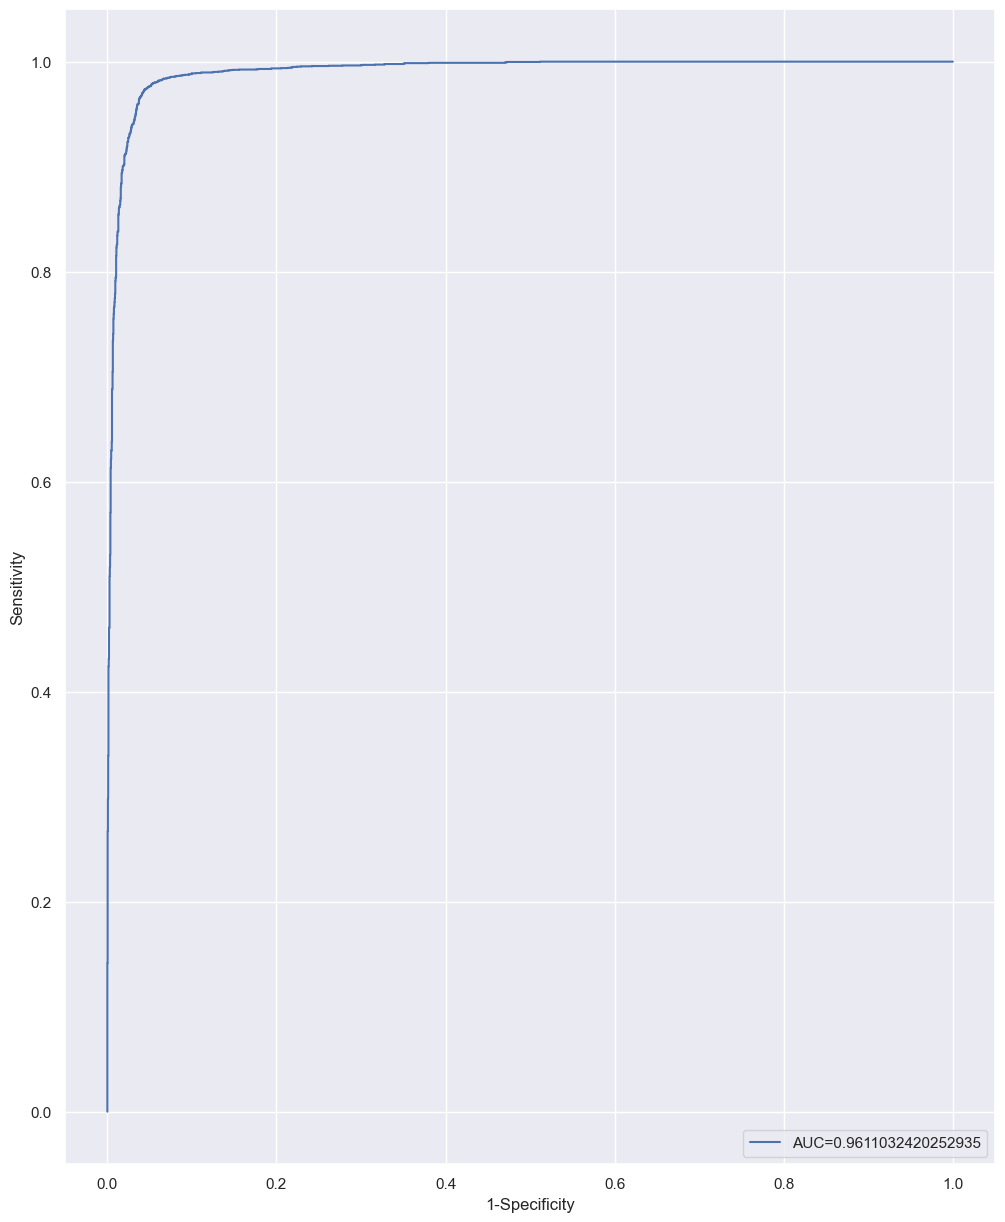

In [45]:
fpr, tpr, _ = roc_curve(y_test,  prob_1)

#create ROC curve
plt.plot(fpr,tpr, label="AUC="+str(xgb_roc_auc))
plt.ylabel('Sensitivity')
plt.xlabel('1-Specificity')
plt.legend(loc=4)
plt.show()
